# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [35]:
dataset_name = "DATASET"

In [89]:
import json

config = {
    "fixed_duration": 3.0,
    "sample_rate": 48000,
    "mel_params": {
      "n_mels": 128,
      "hop_length": 512
    }
}

In [90]:
with open("utils/category_info.json") as f:
    category_info = json.load(f)

mappings = {species: i for i, species in enumerate(category_info.keys())}
mappings["Wind_"]

0

In [91]:
import os
samples_train = {}
train_folder = "E:/Giacomo/Tovanella/DATASET/train"
test_folder = "E:/Giacomo/Tovanella/DATASET/test"
for species in os.listdir(train_folder):
    for audio in os.listdir(os.path.join(train_folder, species)):
        if audio in samples_train:      # same audio in different folders, save the other species
            samples_train[audio]["labels"].append(mappings[species])
            continue
        samples_train[audio] = {
            "file_path": os.path.join(train_folder, species, audio),
            "split": "train",
            "labels": [mappings[species]]
        }


In [92]:
samples_test = {}
for species in os.listdir(test_folder):
    for audio in os.listdir(os.path.join(test_folder, species)):
        labels = [mappings[species]]
        updated = False
        if audio in samples_test:       # adds label
            samples_test[audio]["labels"].extend(labels)
            updated = True
        if audio in samples_train:      # considers training labels
            samples_train[audio]["labels"].extend(labels)       # add test label
            labels = samples_train[audio]["labels"]             # save new labels
        if updated:
            continue
        samples_test[audio] = {
            "file_path": os.path.join(test_folder, species, audio),
            "split": "test",
            "labels": labels
        }

In [93]:
samples = []
for audio_name, props in samples_train.items():
    samples.append(props)
for audio_name, props in samples_test.items():
    samples.append(props)
samples[:2]

[{'file_path': 'E:/Giacomo/Tovanella/DATASET/train\\Certhia familiaris_Eurasian Treecreeper\\20190603_030000_177.wav',
  'split': 'train',
  'labels': [20, 14]},
 {'file_path': 'E:/Giacomo/Tovanella/DATASET/train\\Certhia familiaris_Eurasian Treecreeper\\20190603_030000_187.wav',
  'split': 'train',
  'labels': [20]}]

In [94]:
info_json = {
    "config": config,
    "mappings": mappings,
    "samples": samples
}

In [95]:
with open("utils/dataset_config.json", "w") as f:
    json.dump(info_json, f)

# Dataset and Data Loader
Use the dataset information to create a data loader for the model

In [96]:
import json
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [97]:
class AudioDataset(Dataset):

    def __init__(self, json_path, split="train"):
        with open(json_path, "r") as f:
            data = json.load(f)

        self.config = data["config"]
        self.sample_rate = self.config["sample_rate"]
        self.n_mels = self.config["mel_params"]["n_mels"]
        self.hop_length = self.config["mel_params"]["hop_length"]

        self.label_map = data["mappings"]
        self.num_classes = len(self.label_map)

        self.samples = [sample for sample in data["samples"] if sample["split"] == split]

        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=self.n_mels,
            hop_length=self.hop_length
        )

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        waveform, sr = torchaudio.load(sample["file_path"])

        mel_spec = self.mel_transform(waveform).squeeze(0)  # (n_mels, time)

        # label one-hot
        label_tensor = torch.zeros(self.num_classes)
        for label in sample["labels"]:
            label_tensor[label] = 1.0

        return mel_spec, label_tensor


# Dataset and Data Loader

In [98]:
json_path = "utils/dataset_config.json"
def get_dataloader(json_path, split='train', batch_size=32, shuffle=True):
    dataset = AudioDataset(json_path, split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
get_dataloader(json_path)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


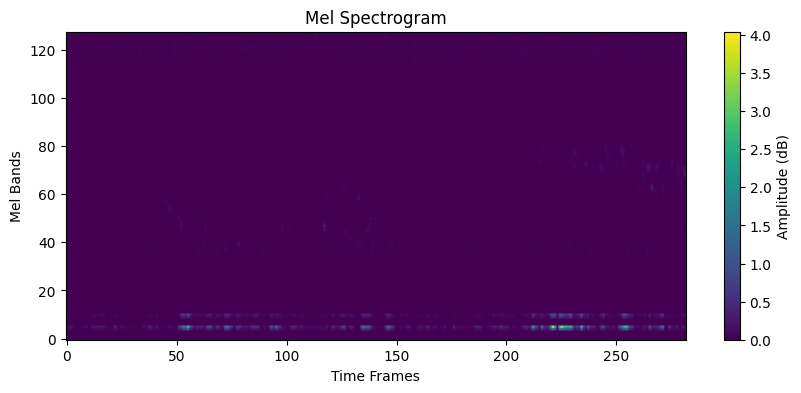

In [102]:
import matplotlib.pyplot as plt

# Carica il dataset
dataset = AudioDataset(json_path, split="train")

# Prendi un esempio
mel_spec, label = dataset[10]  # Cambia l'indice se vuoi vedere altri esempi

# Converti in numpy per visualizzazione
mel_spec = mel_spec.numpy()

# Plotta lo spettrogramma
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec, aspect='auto', origin='lower')
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time Frames")
plt.ylabel("Mel Bands")
plt.title("Mel Spectrogram")
plt.show()
